## Fake Data and Modelling Utility

In [18]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt 
import arviz as az

np.random.seed(110)
def softmax(x): 
    return np.exp(x)/sum(np.exp(x))


In [102]:
## Simulate Data from Random effects model

I = 50 # number of individuals
T = I*10 #number of inidvidual-choice sets/task combinations
K = 5 # number of choices
P = 2 # number of covariates that vary by choice
P2 = 4 #number of covariates that vary by individual
N = T*K # number of rows

X = pd.DataFrame(np.random.normal(0, 1, N*P).reshape(N, P))
X[X.index % K == 0] = 0

X2 = np.random.normal(0, 1, I*P2).reshape(I, P2)
X2

beta = np.random.normal(0, 1, P)
tau = np.random.gamma(4, 2, size=P)

gamma = np.random.normal(1, 1, size=(P, P2))

#lkj = pm.draw(pm.LKJCholeskyCov.dist(n=(I*P), eta=1, sd_dist=pm.Exponential.dist(1.0)), draws=1)
#beta_individual = pm.draw(pm.MvNormal.dist(mu=beta, cov=lkj[1]), draws=I)
cov = np.random.normal(0, 1, P*(P+1)).reshape((P+1, P))
Sigma = np.dot(np.diag(tau), np.dot(np.corrcoef(cov[0], cov[1]), np.diag(tau)))

beta_hierarchical = pm.draw(pm.MvNormal.dist(mu=beta, cov=Sigma), draws=I)
beta_individual = beta_hierarchical + np.dot(X2, gamma.T)


indexes_raw = pd.DataFrame({'individual': np.array([[i]*(10*K) for i in range(I)]).flatten(), 
              'task': np.array([[i]*K for i in range(T)]).flatten(), 
              'row': range(T*K)
            })
indexes = indexes_raw.groupby('task').agg(task_individual = pd.NamedAgg('individual', aggfunc='first'), 
                             start = pd.NamedAgg('row', aggfunc='first'),
                             end = pd.NamedAgg('row', aggfunc='last'))

indexes_raw['task_individual'] = indexes_raw['individual'].astype(str) + '_' + indexes_raw['task'].astype(str)


choices = np.zeros(N)
probs_array = []
utility_array = []
for t in range(T-1):
  utility = np.dot(X.iloc[indexes.start[t]:indexes.start[t+1],], beta_individual[indexes.task_individual[t],])
  utility_array.append(utility)
  probs = softmax(utility)
  probs_array.append(probs)
  choice_raw = np.random.multinomial(n=1, size=1, pvals=probs)
  choices[indexes.start[t]:indexes.start[t+1]] = choice_raw

choices



array([0., 0., 1., ..., 0., 0., 0.])

In [104]:
indexes_raw.head(10)

,individual,task,row,task_individual
0,0,0,0,0_0
1,0,0,1,0_0
2,0,0,2,0_0
3,0,0,3,0_0
4,0,0,4,0_0
5,0,1,5,0_1
6,0,1,6,0_1
7,0,1,7,0_1
8,0,1,8,0_1
9,0,1,9,0_1


In [55]:
pd.DataFrame({'TaskID': range(500), 'probs': probs_array, 'utility': utility_array })

,TaskID,probs,utility
0,0,"[5.530661759392508e-09, 0.9901134348575484, 0....","[0.0, 19.00302259965895, 14.393663209643636, 8..."
1,1,"[0.0001734669268961879, 0.9930537446069423, 0....","[0.0, 8.65255310689463, 1.3046569686804679, 1...."
2,2,"[3.576321805660411e-07, 2.226720832098434e-05,...","[0.0, 4.131365366705797, -4.087537203944378, 1..."
3,3,"[7.545478765146453e-09, 0.999956561630833, 7.2...","[0.0, 18.70227385280201, 2.2625848377920077, 8..."
4,4,"[0.003186152534783419, 0.7337311906542333, 0.2...","[0.0, 5.439328649349288, 4.413326502839652, -1..."
...,...,...,...
495,495,"[0.001735941229059132, 2.451139905443287e-06, ...","[0.0, -6.562751856537485, -10.39985714892442, ..."
496,496,"[3.659138687533144e-07, 4.5927290900236145e-07...","[0.0, 0.22724663193043257, 4.555273672505941, ..."
497,497,"[1.0789739896082196e-06, 0.9143490847165922, 1...","[0.0, 13.64995712831247, -6.875044480580584, 3..."
498,498,"[0.08059528306690125, 0.7236707113939452, 0.18...","[0.0, 2.194896345350853, 0.8475693378699172, -..."


In [115]:
choices


array([0., 0., 1., ..., 0., 0., 0.])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:491: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(


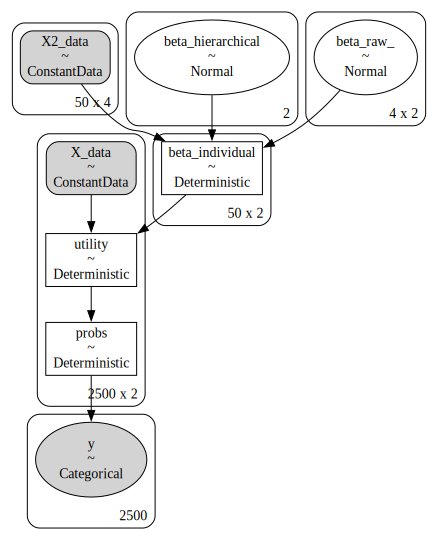

In [117]:
mcmc = True
tasks, tasks_uniques = pd.factorize(indexes_raw.task)
n_beta = 2
corr = False
individual, individual_uniques = pd.factorize(indexes_raw.individual)
individual_indx = list(range(I))
coords= {'task':  tasks, 'individual': individual_indx, 'vars': range(P)}
with pm.Model(coords=coords) as model:

    X_data = pm.Data('X_data', X)
    X2_data = pm.Data('X2_data', X2)
    if corr:
        hierarchical_beta = pm.Normal('beta_hierarchical', 0, 1, size=2)
        packed_chol, _, _ = pm.LKJCholeskyCov(
                'chol', n=P*P2, eta=10.0, sd_dist=pm.Exponential.dist(1.0),
                )

        beta_raw = pm.MvNormal('beta_raw_', mu=0, chol=packed_chol)
        beta = pm.Deterministic('beta_individual', hierarchical_beta  + pm.math.dot(X2, beta_raw.reshape((P2, P))))
    else:
        hierarchical_beta = pm.Normal('beta_hierarchical', 0, 1, size=2)
        beta_raw = pm.Normal('beta_raw_', 0, 1, shape=(P2, P))
        beta = pm.Deterministic('beta_individual', hierarchical_beta + pm.math.dot(X2_data,beta_raw))

        utility = pm.Deterministic('utility', pm.math.dot(X_data, beta))
        probs = pm.Deterministic('probs', pt.special.softmax(utility))

    
    y = pm.Categorical('y', p=probs, observed=choices)
    #y = pm.Potential('y',  pm.math.log(probs)*choices)
    #if mcmc: 
        #idata = pm.sample_prior_predictive()
        #idata.extend(pm.sample(nuts_sampler='numpyro', draws=1000, random_seed=200, target_accept=0.99))
        #idata.extend(pm.sample_posterior_predictive(idata))
    #else: 
    #    approx = pm.fit(100_000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    #    idata = approx.sample(1000)
    #    idata.extend(pm.sample_posterior_predictive(idata))


pm.model_to_graphviz(model)

In [591]:
az.summary(idata, var_names=['beta_hierarchical', 'beta_individual'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_hierarchical[0],0.162,0.884,-1.509,1.833,0.016,0.011,3130.0,4764.0,1.00
beta_hierarchical[1],-0.011,0.898,-1.723,1.643,0.018,0.013,2500.0,4095.0,1.00
"beta_individual[0, 0]",0.617,0.167,0.314,0.940,0.001,0.001,18779.0,14984.0,1.00
"beta_individual[0, 1]",0.056,0.143,-0.213,0.325,0.001,0.001,18176.0,16575.0,1.00
"beta_individual[1, 0]",0.381,1.895,-3.386,3.901,0.078,0.055,921.0,370.0,1.01
"beta_individual[1, 1]",0.001,1.806,-3.739,3.341,0.040,0.028,1918.0,2249.0,1.01
"beta_individual[2, 0]",0.367,1.286,-2.063,2.812,0.023,0.016,2940.0,3775.0,1.00
"beta_individual[2, 1]",-0.043,1.350,-2.694,2.478,0.037,0.026,1504.0,848.0,1.01
"beta_individual[3, 0]",0.266,1.508,-2.814,3.134,0.027,0.020,3212.0,3066.0,1.00
"beta_individual[3, 1]",0.074,1.595,-3.062,3.180,0.040,0.028,1683.0,1385.0,1.00


<Axes: >

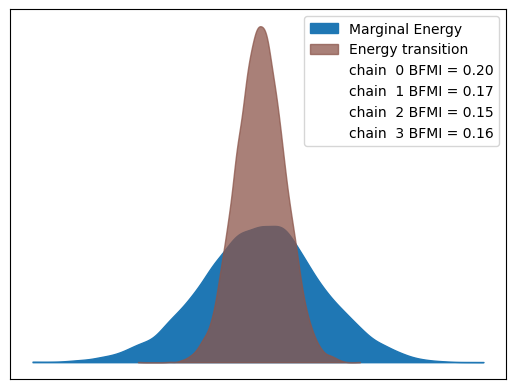

In [592]:
az.plot_energy(idata)

array([[<Axes: title={'center': 'beta_hierarchical'}>,
        <Axes: title={'center': 'beta_hierarchical'}>],
       [<Axes: title={'center': 'beta_individual'}>,
        <Axes: title={'center': 'beta_individual'}>]], dtype=object)

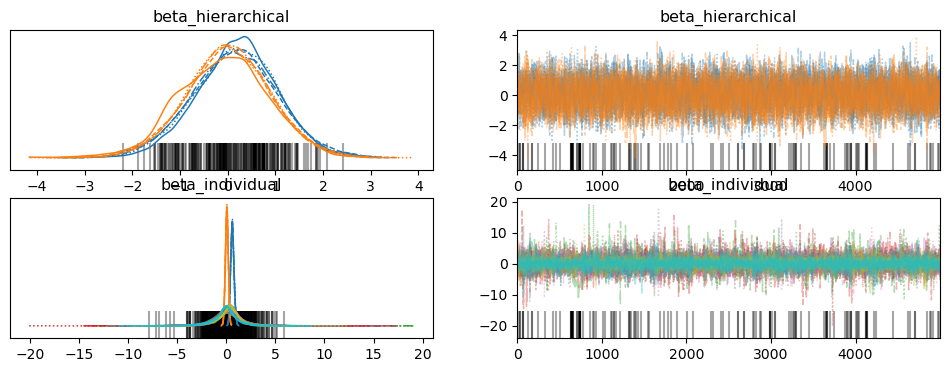

In [593]:
az.plot_trace(idata, var_names=['beta_hierarchical', 'beta_individual'])

<Axes: xlabel='y / y'>

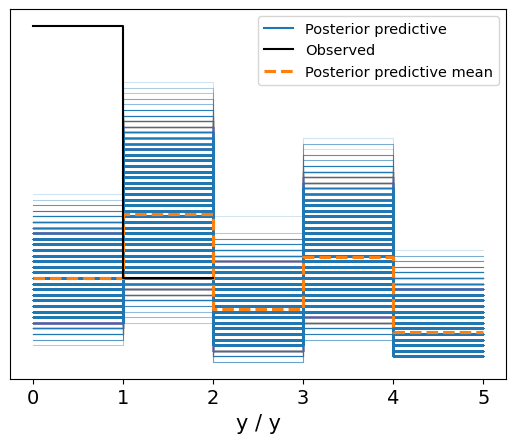

In [594]:
az.plot_ppc(idata)

In [577]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior

In [4]:
n_cars = 3
n_households = 1000
n_params = 10

np.random.seed(33)
cars = np.random.normal(0, 2, size=(n_cars, n_params))
households = np.random.normal(0, 2, size=(n_households, n_params))

betas = np.random.normal(0, 1, size=n_params)

errors = np.random.gumbel(0, 2, size=(n_households, n_cars))

In [5]:
utility = (betas * households) @ cars.T + errors

In [6]:
choice = np.argmax(utility, axis=1)
choice

car_choice_simple = np.zeros_like(utility)
car_choice_simple[np.arange(car_choice_simple.shape[0]), choice] = 1

In [7]:
car_choice_simple.shape

(1000, 3)

In [845]:
cars_oo = cars - cars[0]


In [846]:
cars_oo

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.18678388,  1.93007493,  3.03786313,  3.22923535, -1.73630405,
        -4.92159826, -1.60353814, -2.35561877, -1.80684802, -0.15747783],
       [ 3.72976754,  4.586123  , -1.02127099,  1.80973545, -0.84946075,
        -0.95474209, -2.16184893, -3.60986866,  1.83631113, -1.8319641 ]])

In [847]:
with pm.Model() as m_simple:
    
    betas_rest = pm.Normal('betas', 0, 1, shape=(1, n_params))
    
    utility_ = pm.math.dot((betas_rest * households), cars_oo[1:].T)
    utility_zero = pm.Deterministic('utility', pt.concatenate([pt.zeros((n_households, 1)), utility_], axis=1))
    p = pm.Deterministic('p', pt.special.softmax(utility_zero))

    pm.Multinomial('ll', n=1, p=p, observed = car_choice_simple)
    trace = pm.sample(draws=500, model=m_simple, tune=5000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 16 seconds.


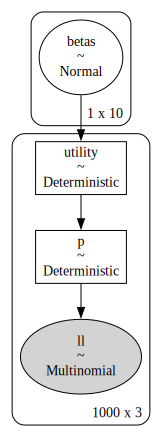

In [848]:
pm.model_to_graphviz(m_simple)

In [849]:
trace


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
cracker_choice_short = pd.read_csv('../data/cracker_choice_short.csv')
df = pd.concat([cracker_choice_short, pd.get_dummies(cracker_choice_short['lastChoice'], prefix='last_choice')], axis=1)
df['customer_id'] = df['personId']

y = pd.get_dummies(df['choice'])

In [10]:
df

,Unnamed: 0,personId,disp.sunshine,disp.keebler,disp.nabisco,disp.private,feat.sunshine,feat.keebler,feat.nabisco,feat.private,...,price.private,choice,lastChoice,personChoiceId,choiceId,last_choice_keebler,last_choice_nabisco,last_choice_private,last_choice_sunshine,customer_id
0,1,1,0,0,0,0,0,0,0,0,...,0.71,nabisco,nabisco,1,1,0,1,0,0,1
1,2,1,1,0,0,0,0,0,0,0,...,0.78,sunshine,nabisco,2,2,0,1,0,0,1
2,3,1,0,0,0,0,0,0,0,0,...,0.78,nabisco,sunshine,3,3,0,0,0,1,1
3,4,1,0,0,0,0,0,0,0,0,...,0.64,nabisco,nabisco,4,4,0,1,0,0,1
4,5,1,0,0,0,0,0,0,0,0,...,0.84,nabisco,nabisco,5,5,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3151,3152,136,0,0,0,0,0,0,0,0,...,0.55,private,private,9,3152,0,0,1,0,136
3152,3153,136,0,0,0,1,0,0,0,0,...,0.65,private,private,10,3153,0,0,1,0,136
3153,3154,136,0,0,0,0,0,0,0,0,...,0.59,private,private,11,3154,0,0,1,0,136
3154,3155,136,0,0,0,0,0,0,0,0,...,0.59,private,private,12,3155,0,0,1,0,136


In [11]:
X = df[['price.sunshine', 'price.keebler','price.nabisco', 'price.private']]
n_params = 3
person_idx, person_uniques = pd.factorize(df['personId'])
n_persons = len(person_uniques)
y = pd.get_dummies(df['choice'])
#y = pd.Categorical(df['choice']).codes

with pm.Model() as m_simple:
    
    betas_raw = pm.Normal('betas_raw', 0, 1, size=n_params)
    #betas_raw = pm.Normal('betas_raw', 0, 1, size=(n_persons, n_params))
    beta = pm.Deterministic('betas', pt.concatenate([[0], betas_raw]))
    #beta = pm.Deterministic('betas', pt.concatenate([np.zeros((n_persons, 1)), betas_raw], axis=1))
    utility_ = pm.Deterministic('utility_', pm.math.dot(X, beta))
    p = pm.Deterministic('p', pt.special.softmax(utility_))

    pm.Multinomial('ll', n=1, p=p, observed = y)
    #pm.Categorical('y', p=p, observed=y)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(nuts_sampler='numpyro', draws=5000, random_seed=200, target_accept=0.99))
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(m_simple)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:491: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pytensor/tensor/special.py:501: UserWarning: Softmax no longer converts a vector to a row matrix.
  warnings.warn(
Sampling: [betas_raw, ll]


ValueError: Incompatible Elemwise input shapes [(3156, 4), (1, 3156)]

In [852]:
az.summary(idata, var_names=['betas_raw', 'betas'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas_raw[0],-4.627,0.189,-4.968,-4.260,0.002,0.001,14482.0,12355.0,1.0
betas_raw[1],-2.771,0.092,-2.942,-2.597,0.001,0.001,12608.0,11880.0,1.0
betas_raw[2],5.311,0.120,5.083,5.532,0.001,0.001,12205.0,11106.0,1.0
betas[0],0.000,0.000,0.000,0.000,0.000,0.000,20000.0,20000.0,NaN
betas[1],-4.627,0.189,-4.968,-4.260,0.002,0.001,14482.0,12355.0,1.0
betas[2],-2.771,0.092,-2.942,-2.597,0.001,0.001,12608.0,11880.0,1.0
betas[3],5.311,0.120,5.083,5.532,0.001,0.001,12205.0,11106.0,1.0


<Axes: xlabel='y / y'>

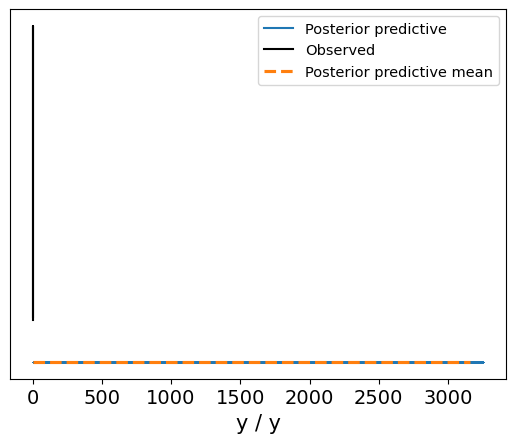

In [853]:
az.plot_ppc(idata)

In [838]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data